Process: TSFEL feature extraction, log-transform, scaling, pca, and cop-kmeans clustering

Also some plots


created 5/23/2024
updated 6/10/2024

**Imports, Functions, Parameters**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing
import yaml
from glob import glob
import h5py

import tsfel
import random
from datetime import timedelta
import calendar
from tsfel import time_series_features_extractor

from copkmeans.cop_kmeans import cop_kmeans #from https://github.com/Behrouz-Babaki/COP-Kmeans/tree/master, installed 5/25/2023

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples


In [2]:
#get cluster id from template_name
def get_clid(template_str):
    clid_get = (template_str.split('_')[-1])
    return clid_get

#get station name from template name
def getnet_sta(template_str): #for normalized
    t_net = template_str.split('_')[0]
    t_sta = template_str.split('_')[1]
    netsta = t_net+'_'+t_sta
    return netsta

#color map for plotting
def get_cmap(n, name='viridis'): #hsv
#     Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     RGB color; the keyword argument name must be a standard mpl colormap name.
    return plt.cm.get_cmap(name, n)

#from https://stackoverflow.com/questions/57340166/how-to-plot-the-pricipal-vectors-of-each-variable-after-performing-pca
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, s=10) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center')

#get ncom from idealv using scaling
def ncom_idealv_scaled(ncom_list,idealv,X): #ncom_list is list of options, idealv is ideal variance, x is the data
    sum_list = [] #will be a list of cumulative explained variance ratio for each ncom
    for n_com in ncom_list:
        
        pca = PCA(n_components=n_com) #get the pca function
        scaler = StandardScaler().set_output(transform="pandas")
        scaled_X = scaler.fit_transform(X) #normalize data for scaling
        
        pca.fit(scaled_X) #use pca on data X
        x_new = pca.transform(scaled_X)
#         print(x_new.shape)
        
#         myplot(x_new[:,0:2], pca.components_.T) 
#         plt.show()
#         plt.close()

        vr = pca.explained_variance_ratio_
        sum_list.append(sum(vr))
        
        
        #plot explained varience for each component
#         plt.bar(x=np.arange(0,len(vr),1),height=vr)
# #         plt.yscale('log') #in case drop in vr with each component is large
#         plt.show()
#         plt.close()
        
        print(f'{n_com} components -> {sum(vr)} variance ratio')


    diff_list = [abs(i-idealv) for i in sum_list] #find difference from idealv across ncom_list
    #look through ncom_list to find the ncom closest to idealv
    ncom = ncom_list[diff_list.index(min(diff_list))] #get the minimum difference, find its index, pull from ncom_list
    
    plt.scatter(x=ncom_list,y=sum_list,color='black')
    plt.xlabel('Number of Components')
    plt.ylabel('Sum of Explained Variance')
    plt.show()
    plt.close()
    
    print('auto ncom =',ncom)
    return ncom

#create must-link constraints across stations for cop-kmeans
def must_links(template_name): #input a list of template names containing cluster ID
    ml = [] #list of tuples of must-link pairs by index

    cl_list = np.unique([get_clid(i) for i in template_name])

    idx_grp_list = [] #list of lists of group indexes, not necessary
    for cl in cl_list:
        cl_idx_list = [] #will be a list of indexes in a group (same cluster ID, different station) 
        for tname in template_name:
            if get_clid(tname)==cl:
                cl_idx_list.append(list(template_name).index(tname))
        idx_grp_list.append(cl_idx_list)
        for idx in cl_idx_list: #for each index in this group
            if idx==min(cl_idx_list): #no need to pair min with itself
                continue
            else:
                ml.append((min(cl_idx_list),idx)) #pair each index with the min

    return ml #list of tuples that can be inserted into cop-kmeans clustering

In [3]:
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

smooth_length = config['smooth_length']
fs = config['fs']
tb = config['tb']
ta = config['ta']
fqmin = config['fqmin']
fqmax = config['fqmax']
chan = config['chan']
homedir = config['homedir']
readdir = config['readdir']
minsta = config['minsta']
grid_length = float(config['grid_length'])
grid_height = float(config['grid_height'])
step = config['step']
t_step = config['t_step']
vs_min = config['vs_min']
vs_max = config['vs_max']
vs_step = config['vs_step']
volc_lat_lon = config['volc_lat_lon']
volc_list_names = config['volc_list_names']

vv = config['vv']
# vv=0


print(volc_list_names[vv])

k=6 #number of clusters
tsfel_name = f'{homedir}tsfel_clustering/{volc_list_names[vv]}_tsfel_features.csv'
cop_kmeans_name = f'{homedir}tsfel_clustering/{volc_list_names[vv]}_COPkmeans{k}.csv'

St_Helens


Pull in template waveforms (needed for TSFEL feature extraction and plots)

In [4]:
#pull in h5 for volcano

all_temps = []
all_waves = []

for filepath in glob(f'/home/smocz/expand_redpy_new_files/h5/normalized_{volc_list_names[vv].lower()}_templates_*.h5'):
    net = filepath.split('_')[-2]
    with h5py.File(filepath, "r") as f: #pull in fingerprints
        template_name = f["template_name"][()]
        waveforms = f["waveforms"][()]
#         print(f.keys()) #print what data is in this file
    [all_temps.append(i) for i in template_name]
    [all_waves.append(i) for i in waveforms]
    
all_waves = np.array(all_waves)
all_temps = [str(i)[2:-1] for i in all_temps]

In [5]:
print(all_temps[0])

CC_AWST_rpst_22


**TSFEL Feature Extraction**

(can be skipped if csv already saved)

In [ ]:
eq_Z = all_waves

In [ ]:
# FEATURE EXTRACTIONS #
cfg_file = tsfel.get_features_by_domain()

# Extract features for earthquakes
features_eqz = pd.DataFrame([])
for i in range(0,len(all_temps)+1):
    try:
    
        df = time_series_features_extractor(cfg_file, eq_Z[i], fs=40,)
        df['template'] = all_temps[i]
        features_eqz = pd.concat([features_eqz,df])
        
    except:
        pass

In [ ]:
features_eqz.head()

In [ ]:
#save features to csv

features_eqz.to_csv(tsfel_name)

**Log-transform**

Check if log-normal and then update

In [6]:
#read in the tsfel features csv
features_df = pd.read_csv(tsfel_name)

df = features_df.copy() #create a copy for manipulating
df.dropna(inplace=True)
df.head()
df.drop(['template'], axis=1, inplace=True)
df.isna().sum().any()

False

In [7]:
# Step 1: Calculate skewness for each feature
skewness = df.apply(lambda x: x.skew())

# Step 2: Identify features with high positive skewness (right-skewed)
log_normal_features = skewness[skewness > 1.0].index.tolist()

print(f'{len(log_normal_features)} features are log-normal, out of {len(df.keys())} total features')

322 features are log-normal, out of 390 total features


In [8]:
#transforma all log-normal features

df_log = df.copy()
df_log[log_normal_features] = np.log(df_log[log_normal_features]) # log transform the skewed features

# drop the features with Nan, Inf, Zeros from the data frames.
df_log.dropna(inplace=True,axis=1)
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log.dropna(inplace=True,axis=1)
df_log.replace(0, np.nan)
df_log.dropna(inplace=True,axis=1)
df_log.isna().sum().any()

/home/smocz/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/smocz/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


False

In [9]:
df_log.describe() #look at stats

,Unnamed: 0,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,...,0_Median absolute diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate
count,35692.0,35692.000000,35692.000000,35692.000000,35692.000000,35692.000000,35692.000000,35692.000000,35692.000000,35692.000000,...,35692.000000,35692.000000,35692.000000,35692.000000,35692.000000,35692.000000,3.569200e+04,35692.000000,35692.000000,35692.000000
mean,0.0,-12.998253,-16.011202,-15.714157,-15.186329,-14.594100,-13.787545,-12.876148,-12.032494,-11.292748,...,-3.850429,6.455591,161.259134,1.613032,6.455593,8.169492,-9.311549e-10,4.935488,-1.172389,6.783571
std,0.0,1.545878,1.617846,1.858589,2.224986,2.454195,2.573375,2.586898,2.511085,2.357078,...,0.770669,0.182567,11.309253,0.270296,0.182553,0.002301,1.290139e-07,0.506025,0.712489,0.277038
min,0.0,-29.554910,-29.669475,-24.195269,-23.918821,-23.883266,-23.927966,-23.937471,-23.440462,-21.800577,...,-10.371541,5.379897,4.000000,0.197139,5.379897,8.166252,-1.094685e-06,1.771201,-5.498203,5.736572
25%,0.0,-13.955101,-17.024915,-16.920320,-16.718983,-16.356421,-15.602476,-14.632072,-13.701779,-12.859673,...,-4.285768,6.354370,155.000000,1.499270,6.354370,8.167985,-4.653081e-08,4.623816,-1.622342,6.602588
50%,0.0,-12.874176,-15.933160,-15.724371,-15.332106,-14.691866,-13.759058,-12.808941,-11.968521,-11.156973,...,-3.744617,6.455199,162.000000,1.687364,6.456770,8.169045,-9.054757e-11,4.992307,-1.114526,6.787845
75%,0.0,-11.916073,-14.925288,-14.546403,-13.692228,-12.859016,-11.934020,-11.010121,-10.220142,-9.620530,...,-3.303936,6.551080,168.000000,1.801407,6.549651,8.170437,4.423511e-08,5.291473,-0.663280,6.965316
max,0.0,-7.911310,-10.089575,-8.727480,-7.688794,-7.328788,-6.078148,-5.326596,-4.916391,-4.653395,...,-1.036395,7.471932,258.000000,1.996864,7.471363,8.267648,1.404184e-06,7.266416,0.976407,8.158230


**PCA and Scaling**

2 components -> 0.5315611811327199 variance ratio
3 components -> 0.6578446374374389 variance ratio
4 components -> 0.7099223508549292 variance ratio
5 components -> 0.7309632748865715 variance ratio
8 components -> 0.7669555395806131 variance ratio
10 components -> 0.7822422299735732 variance ratio
12 components -> 0.7935561865302202 variance ratio
20 components -> 0.8261220351948094 variance ratio
30 components -> 0.8556019727524894 variance ratio
40 components -> 0.8786545540044882 variance ratio
50 components -> 0.8966750191731108 variance ratio


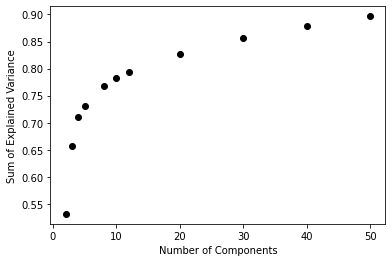

auto ncom = 30


In [10]:
#get ncom (number of components) for PCA, using sum of explained variance.

ncom = ncom_idealv_scaled(ncom_list=[2,3,4,5,8,10,12,20,30,40,50],idealv=0.86,X=df_log.to_numpy())

In [11]:
X = df_log.to_numpy() #X is data/features (log-transformed)

pca = PCA(n_components=ncom) #get the pca function
scaler = StandardScaler().set_output(transform="pandas") #define scaler
scaled_X = scaler.fit_transform(X) #normalize data for scaling

pca.fit(scaled_X) #use pca on data scaled_X
x_new = pca.transform(scaled_X)

cop-kmeans

In [ ]:
from copkmeans.cop_kmeans import cop_kmeans #from https://github.com/Behrouz-Babaki/COP-Kmeans/tree/master
from time import time

ml = must_links(all_temps)

#kmeans
t00 = time()
sil_list = [] #list of silhouette scores
cop_list = [] #list of cluster labels
center_list = []
i = 0
while i < 10:
    t0 = time()
    cop_clusters, cop_centers = cop_kmeans(dataset=x_new, k=k,ml=ml,initialization='kmpp',max_iter=300,tol=1e-4)
    t1 = time()
    # print(f'{t1-t0} seconds for COP-Kmeans')
    silhouette_avg = silhouette_score(x_new, np.array(cop_clusters))
    print(f'sil avg: {silhouette_avg}', end=', ')
    sil_list.append(silhouette_avg)
    cop_list.append(cop_clusters)
    center_list.append(cop_centers)
    i = i +1
t11 = time()
print(f'{t11-t00} seconds to find largest silhouette score of 10 attempts')

cop_centers = center_list[sil_list.index(max(sil_list))] #find the cluster centers with the highest silouhette score
cop_clusters = cop_list[sil_list.index(max(sil_list))] #find the cluster labels with the highest silouhette score

In [ ]:
save_df = pd.DataFrame(data=[])
save_df['template']=all_temps
save_df['kmeansID']=cop_clusters
display(save_df)

In [ ]:
save_df.to_csv(cop_kmeans_name,index=False)

### COP-Kmeans Analysis ###

In [42]:
#read csv

groups_df = pd.read_csv(cop_kmeans_name)
groups_df.head()

,template,kmeansID
0,CC_AWST_rpst_22,3
1,CC_AWST_rpst_145,3
2,CC_AWST_rpst_265,3
3,CC_AWST_rpst_329,3
4,CC_AWST_rpst_348,3


In [43]:
#add waveform to dataframe
groups_df['waveform']= [i for i in all_waves]

In [44]:
groups_df.head()

,template,kmeansID,waveform
0,CC_AWST_rpst_22,3,"[0.026959804102720322, 0.03474279726937408, 0...."
1,CC_AWST_rpst_145,3,"[0.011048347455098967, 0.006779067934422391, 0..."
2,CC_AWST_rpst_265,3,"[-0.04403478267968358, -0.04546598459270228, 0..."
3,CC_AWST_rpst_329,3,"[-0.0026034552993298484, -0.00869994360233075,..."
4,CC_AWST_rpst_348,3,"[0.004764780029812119, -0.001202903524712484, ..."


In [54]:
#GET ONLY ONE STATION FOR PLOTTING. OPTIONAL#
#helps keep plot smaller and compare across clusters, instead of stations

plot_station = np.unique([getnet_sta(i) for i in groups_df['template']])[1] #which station to show waveforms from, 
#format 'NN_SSS' where nn is network id and sss is station id
#by default, the first one in the csv (plot_station = getnet_sta(groups_df['template'][0]))

print(plot_station)

#get one station
new_temps = []
new_waves = []
new_kmeans = []
for t,w,km in zip(groups_df['template'],groups_df['waveform'],groups_df['kmeansID']):
    if getnet_sta(t) == plot_station:
        new_temps.append(t)
        new_waves.append(w)
        new_kmeans.append(km)
        
groups_df = pd.DataFrame({"template":list(new_temps),"waveform":list(new_waves),"kmeansID":list(new_kmeans)})

CC_JRO


In [55]:
groups_df

,template,waveform,kmeansID
0,CC_JRO_rpst_12,"[0.012195553987046479, -0.028649236677617415, ...",0
1,CC_JRO_rpst_22,"[-0.005347205255919299, -0.0066934836473993035...",3
2,CC_JRO_rpst_144,"[0.005967498054878436, -0.004497110816579518, ...",3
3,CC_JRO_rpst_145,"[-0.03486515688587843, -0.03158840069092085, -...",3
4,CC_JRO_rpst_178,"[0.003493673988933865, -0.0022715527141044536,...",2
...,...,...,...
1135,CC_JRO_rpst_3495,"[0.057258899921239254, 0.01846068164009146, -0...",0
1136,CC_JRO_rpst_3506,"[0.021282427733700295, -0.006765547594056905, ...",0
1137,CC_JRO_rpst_3509,"[0.019639882651255748, 0.0040452179549886735, ...",0
1138,CC_JRO_rpst_3510,"[0.1080924437903128, 0.1664294922122813, 0.084...",0


number of clusters = 6
277 waveforms, 140 waveforms, 215 waveforms, 140 waveforms, 159 waveforms, 209 waveforms, showing plot...


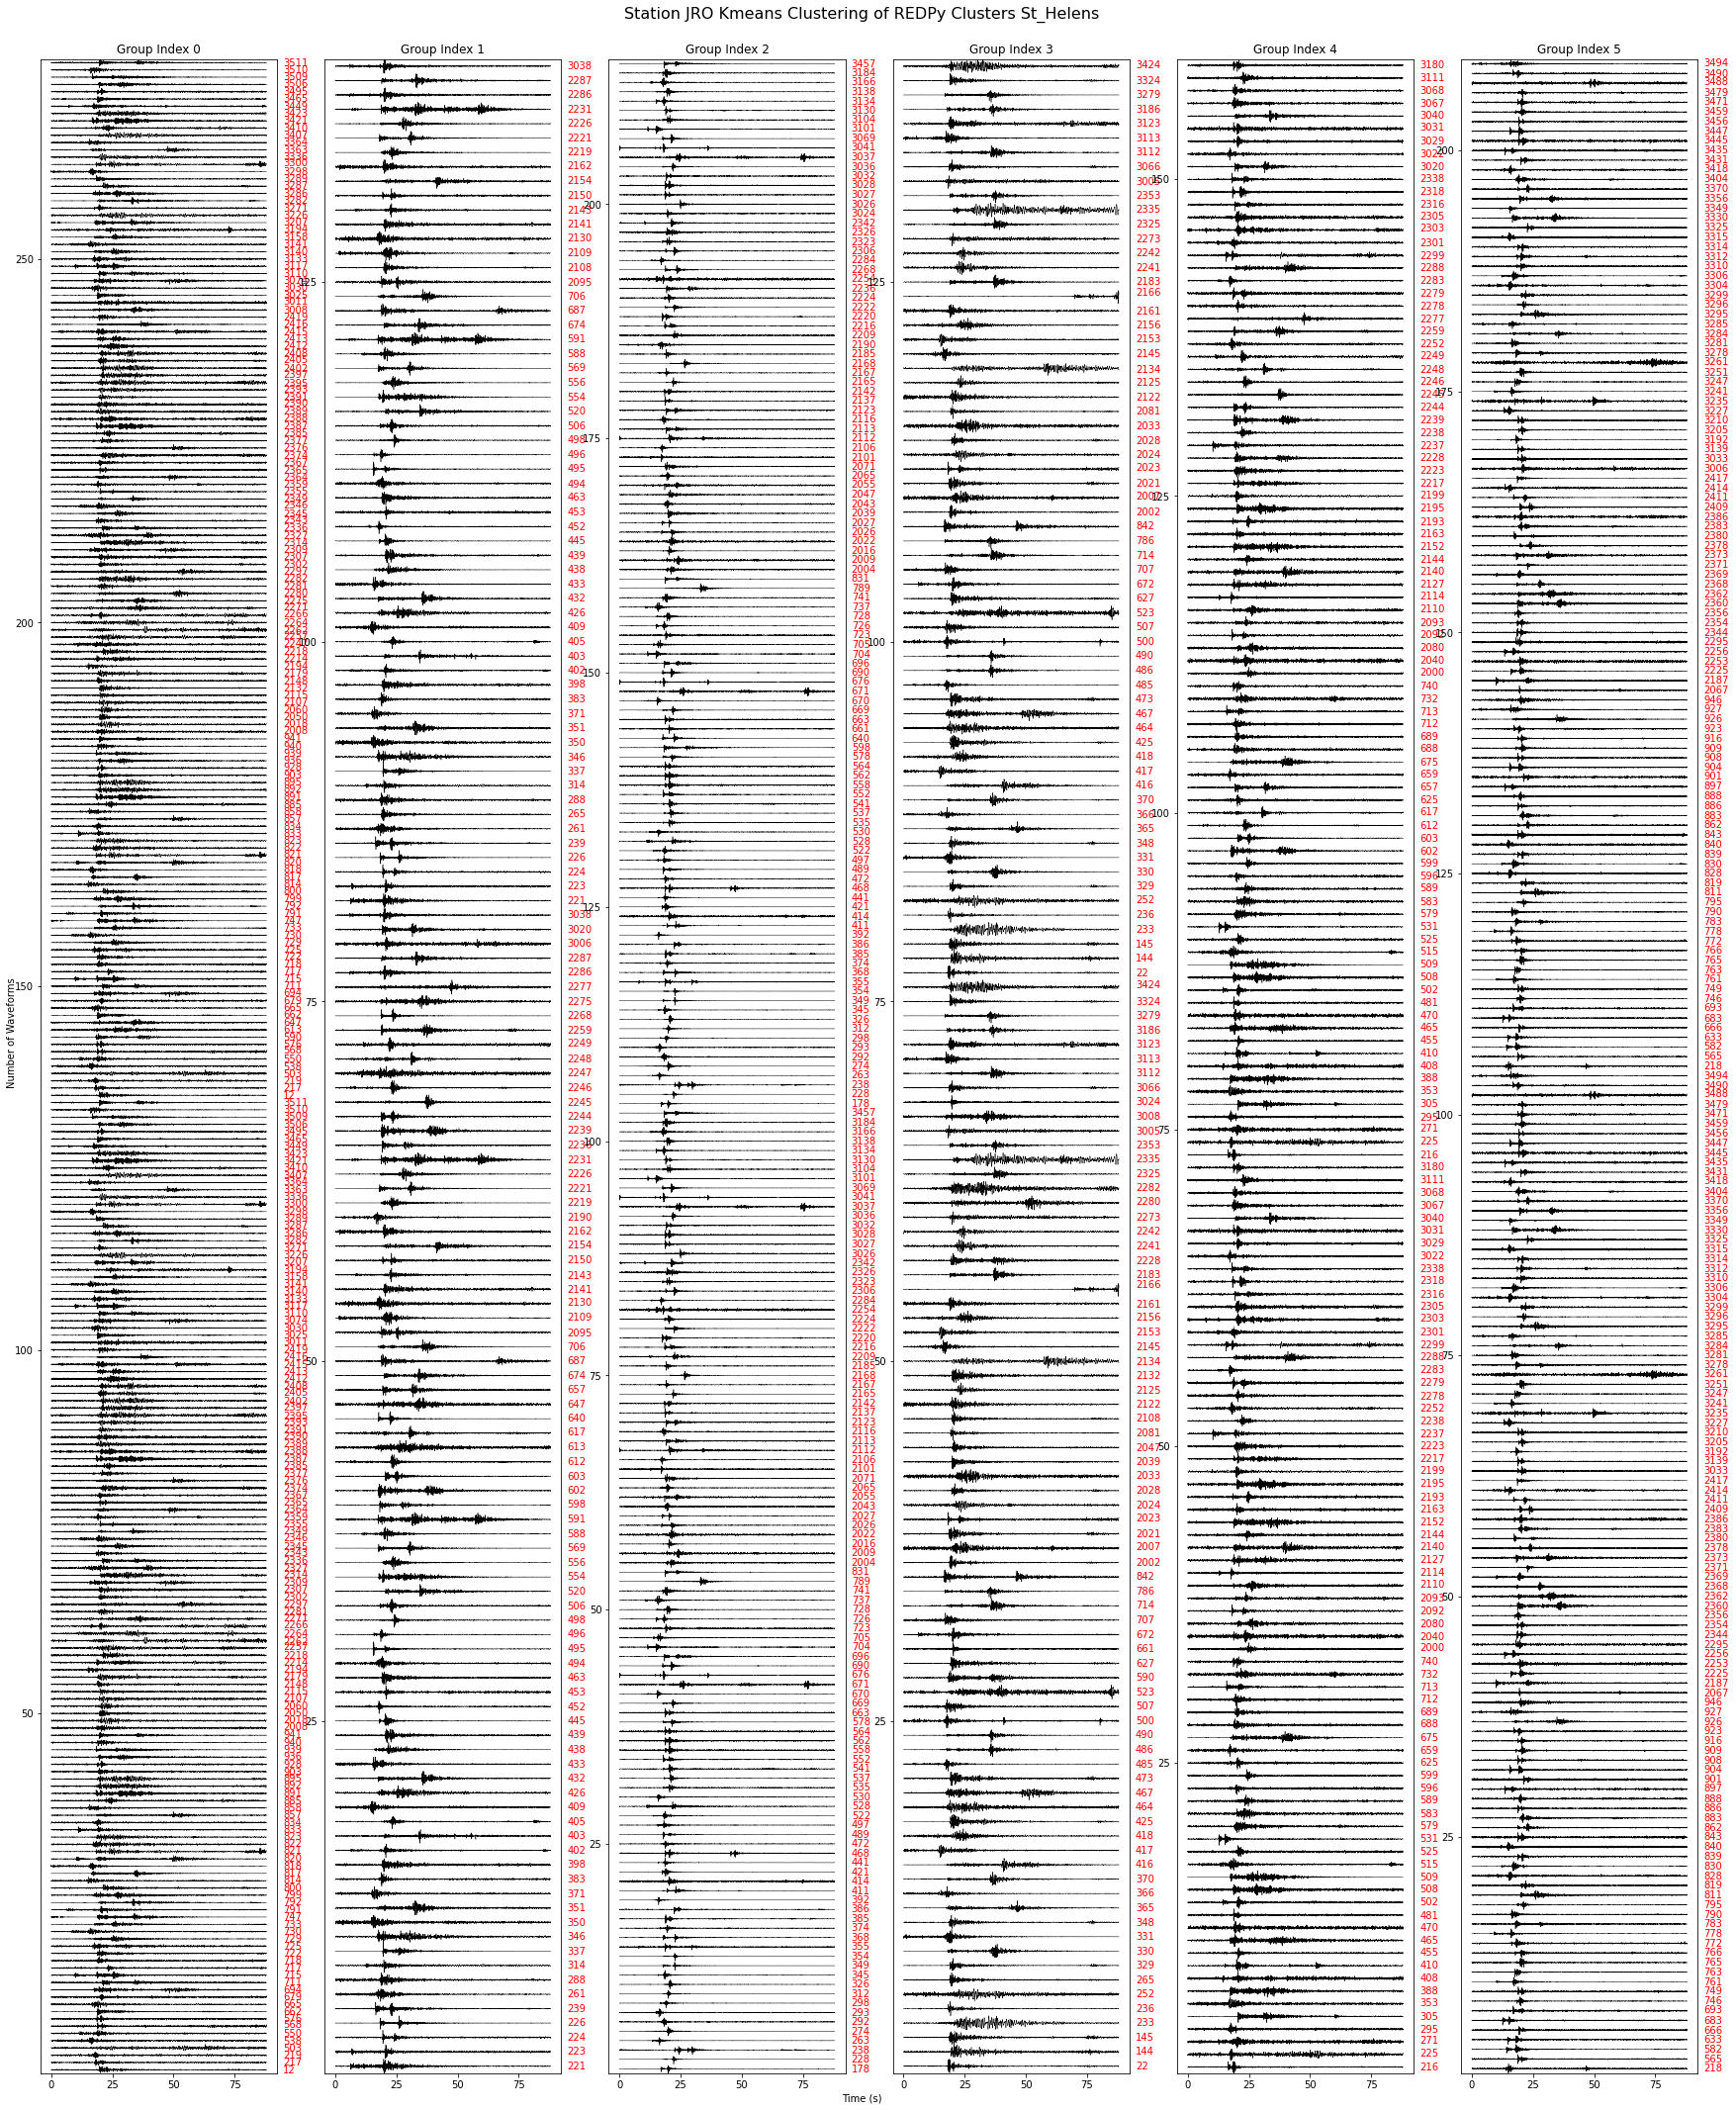

In [57]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import math
from obspy import Trace

k= max([int(i) for i in groups_df['kmeansID'].values.tolist()])+1
plot_station = groups_df['template'][0].split('_')[1] #which station to show waveforms from
if plot_station:
    plot_name = f'Station {plot_station} Kmeans Clustering of REDPy Clusters {volc_list_names[vv]}'
    svg_name = f'/home/smocz/expand_redpy_new_files/newcl_method_{plot_station}_{k}COPkmeans_{volc_list_names[vv]}.svg'
else:
    plot_name = f'Kmeans Clustering of REDPy Clusters {volc_list_names[vv]}'
    svg_name = f'/home/smocz/expand_redpy_new_files/newcl_method_{k}COPkmeans_{volc_list_names[vv]}.svg'

print('number of clusters =',k)

ax_list = np.arange(0,k,1) #list of groups, can do np.arange(0,n_clusters,1)

ncols = k #number of columns, can be set manually
nrows = math.ceil(k/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*4,nrows*30))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.suptitle(plot_name,fontsize=16)
# fig.set_tight_layout(True)
fig.tight_layout(rect=[0, 0, 1, 0.975])


for aa,ax_n in enumerate(ax_list):#for each subplot
#     print(f'----{ax_n}----')
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1,aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    ax.set_title(f'Group Index {ax_n}') #label
    
    
    wave_list = [Trace(i) for i in groups_df[groups_df['kmeansID']==aa]['waveform'].values.tolist()] #list of waveforms for a Kmeans group
    name_list = [get_clid(i) for i in groups_df[groups_df['kmeansID']==aa]['template'].values.tolist()] #list of names for a Kmeans group

    print(len(wave_list),'waveforms', end=', ')
    
    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(wave_list):
        ax.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        
    for line, name in zip(ax.lines, name_list): #label each waveform with the cluster id
        y = line.get_ydata()[-1] #find the y value where the line ends
        ax.annotate(name, xy=(1,y), xytext=(6,0), color='red', 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=10, va="center")
    
    x = np.arange(0,len(wave.data),1) #get np array of x points
    xscale = 40 #samling rate in hz
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/xscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.xaxis.set_major_formatter(ticks) #set ticks
#     ax.set_xlabel('Time (s)')
    
    y = np.arange(1,len(wave_list),1) #get np array of y points
    #yscale defined above
    ticks = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/yscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.yaxis.set_major_formatter(ticks) #set ticks
    ax.set_ylim(1,(len(wave_list)*yscale)+(.5*yscale))
#     ax.set_ylabel('Number of Waveforms')
    
fig.delaxes(ax0) #remove unused ax
fig.text(0.5, 0.0, 'Time (s)', ha='center')
fig.text(0.0, 0.5, 'Number of Waveforms', va='center', rotation='vertical')

print('showing plot...')


fig.savefig(svg_name)